# Assignment #4: Extracting syntactic groups using machine-learning techniques: Keras Version
Author: Pierre Nugues

In this assignment, you will create a system to extract syntactic groups from a text. You will apply it to the CoNLL 2000 dataset. You will train your models with either Keras or PyTorch. Choose one of these framework following the name of the notebook.

Before you start the assignment, please run the prerequisites from the prerequistites notebook.

## Objectives

The objectives of this assignment are to:
* Write a program to detect partial syntactic structures called groups or chunks
* Understand the principles of supervised machine learning techniques applied to language processing
* Use a popular machine learning toolkit: either Keras or PyTorch
* Write a short report of 2 to 3 pages on the assignment

## Preliminaries

In [10]:
!pip list

Package                           Version
--------------------------------- -----------
absl-py                           1.2.0
altair                            4.2.0
appdirs                           1.4.4
appnope                           0.1.2
argon2-cffi                       20.1.0
astunparse                        1.6.3
async-generator                   1.10
attrs                             21.2.0
backcall                          0.2.0
bleach                            3.3.0
blinker                           1.4
cachetools                        5.2.0
certifi                           2021.5.30
cffi                              1.14.5
charset-normalizer                2.0.12
click                             8.1.3
commonmark                        0.9.1
conlleval                         0.2
cycler                            0.11.0
debugpy                           1.3.0
decorator                         5.0.9
defusedxml                        0.7.1
distlib                     

In [13]:
%%capture
!conda install pip

In [18]:
! /Users/nils/opt/anaconda3/bin/pip install conlleval

  Using cached conlleval-0.2-py3-none-any.whl (5.4 kB)


### Imports

In [19]:
import os
import bs4
import requests
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import numpy as np
from numpy import dot
from numpy.linalg import norm

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical

import conlleval

### Seeds
Making things reproduceable

In [20]:
random.seed(1234)
np.random.seed(1234)
keras.utils.set_random_seed(1234)

### Constants

In [21]:
EMBEDDING_DIM = 100
LSTM_HIDDEN_DIM = 128

### The datasets

You may need to adjust the paths to load the datasets from your machine.

In [22]:
train_file = 'corpus/train.txt'
test_file = 'corpus/test.txt'

## Reading the files

You will now convert the dataset in a Python data structure. Read the functions below to load the datasets. They store the corpus in a list of sentences. Each sentence is a list of rows, where each row is a dictionary.

In [23]:
def read_sentences(file):
    """
    Creates a list of sentences from the corpus
    Each sentence is a string
    :param file:
    :return:
    """
    f = open(file).read().strip()
    sentences = f.split('\n\n')
    return sentences

In [24]:
def split_rows(sentences, column_names):
    """
    Creates a list of sentence where each sentence is a list of lines
    Each line is a dictionary of columns
    :param sentences:
    :param column_names:
    :return:
    """
    new_sentences = []
    for sentence in sentences:
        rows = sentence.split('\n')
        sentence = [dict(zip(column_names, row.split())) for row in rows]
        new_sentences.append(sentence)
    return new_sentences

### Loading dictionaries

The CoNLL 2000 files have three columns: The wordform, `form`, its part of speech, `pos`, and the tag denoting the syntactic group also called the chunk tag, `chunk`.

In [ ]:
column_names = ['form', 'pos', 'chunk']

We load the corpus as a list of dictionaries

In [ ]:
train_sentences = read_sentences(train_file)
train_dict = split_rows(train_sentences, column_names)
train_dict[10:11]

[[{'form': 'He', 'pos': 'PRP', 'chunk': 'B-NP'},
  {'form': 'reckons', 'pos': 'VBZ', 'chunk': 'B-VP'},
  {'form': 'the', 'pos': 'DT', 'chunk': 'B-NP'},
  {'form': 'current', 'pos': 'JJ', 'chunk': 'I-NP'},
  {'form': 'account', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'deficit', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'will', 'pos': 'MD', 'chunk': 'B-VP'},
  {'form': 'narrow', 'pos': 'VB', 'chunk': 'I-VP'},
  {'form': 'to', 'pos': 'TO', 'chunk': 'B-PP'},
  {'form': 'only', 'pos': 'RB', 'chunk': 'B-NP'},
  {'form': '#', 'pos': '#', 'chunk': 'I-NP'},
  {'form': '1.8', 'pos': 'CD', 'chunk': 'I-NP'},
  {'form': 'billion', 'pos': 'CD', 'chunk': 'I-NP'},
  {'form': 'in', 'pos': 'IN', 'chunk': 'B-PP'},
  {'form': 'September', 'pos': 'NNP', 'chunk': 'B-NP'},
  {'form': '.', 'pos': '.', 'chunk': 'O'}]]

## Embeddings

### Reading the embeddings

In [ ]:
embedding_file = 'corpus/glove.6B.100d.txt'

Apply the function below that reads GloVe embeddings and store them in a dictionary, where the keys will be the words and the values, the embedding vectors.

In [ ]:
def read_embeddings(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    glove = open(file, encoding='utf8')
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embeddings[word] = vector
    glove.close()
    return embeddings

In [ ]:
# We read the embeddings
embeddings_dict = read_embeddings(embedding_file)
embedded_words = sorted(list(embeddings_dict.keys()))

In [ ]:
'# words in embedding dictionary: {}'.format(len(embedded_words))

'# words in embedding dictionary: 400000'

### Understanding the embeddings

In [ ]:
embedded_words[100000:100010]

['chording',
 'chordoma',
 'chordophones',
 'chords',
 'chore',
 'chorea',
 'chorene',
 'choreograph',
 'choreographed',
 'choreographer']

In [ ]:
embeddings_dict['chords'][:20]

array([-0.51973,  1.0395 ,  0.20924,  0.16285,  0.7209 ,  0.81524,
       -0.34641, -0.76654, -0.49576,  0.24634,  0.44094,  0.37701,
       -0.16396,  0.2775 ,  0.16563,  0.43869, -1.0887 ,  0.12663,
        0.66916,  0.3578 ], dtype=float32)

Using a cosine similarity, write a `closest(target_word, embeddings, count=10)` that computes the 10 closest words to the words _table_, _france_, and _sweden_.

In [62]:
# Write your code here
from heapq import nlargest
def cosine(u, v):
    return np.dot(u, v) / np.linalg.norm(u) / np.linalg.norm(v)


def closest(target_word, embeddings, count = 10):
    cosines = {other_word : cosine(embeddings.get(target_word), embedding) for other_word, embedding in embeddings.items()}
    cosines = sorted(cosines, reverse = True, key = lambda x: cosines[x])[0:10]
    return cosines
    
    

In [65]:
target_words = ['table', 'france', 'sweden']
print([closest(w, embeddings_dict) for w in target_words])

[['table', 'tables', 'place', 'bottom', 'room', 'side', 'sit', 'top', 'here', 'pool'], ['france', 'belgium', 'french', 'britain', 'spain', 'paris', 'germany', 'italy', 'europe', 'netherlands'], ['sweden', 'denmark', 'norway', 'finland', 'netherlands', 'austria', 'switzerland', 'germany', 'swedish', 'belgium']]


## Extracting the $\mathbf{X}$ and $\mathbf{Y}$ Lists of Symbols from the Datasets

For each sentence, you will build an input sequence, $\mathbf{x}$, corresponding to the words and an output one, $\mathbf{y}$, corresponding to the chunk tags.

Write a `build_sequences(corpus_dict, key_x='form', key_y='chunk', tolower=True)` function that, for each sentence, returns the $\mathbf{x}$ and $\mathbf{y}$ lists of symbols consisting of words and chunk tags. Set the words in lower case if `tolower` is true.

For the 11th sentence of the training set, you should have:<br/>
`x = ['he',  'reckons',  'the',  'current',  'account',  'deficit',  'will',  'narrow',  'to',  'only',  '#',  '1.8',  'billion',  'in',  'september',  '.']`

`y = ['B-NP', 'B-VP', 'B-NP', 'I-NP', 'I-NP', 'I-NP', 'B-VP', 'I-VP', 'B-PP', 'B-NP', 'I-NP', 'I-NP', 'I-NP', 'B-PP', 'B-NP', 'O']`

In [80]:
def build_sequences(corpus_dict, key_x='form', key_y='chunk', tolower=True):
    xs = [[word[key_x].lower() if tolower else word[key_x] for word in sample] for sample in corpus_dict] 
    ys = [[word[key_y] for word in sample] for sample in corpus_dict] 
    return xs, ys

In [81]:
X_train_symbs, Y_train_symbs = build_sequences(train_dict, key_x='form', key_y='chunk')

In [82]:
print(X_train_symbs[10])

['he', 'reckons', 'the', 'current', 'account', 'deficit', 'will', 'narrow', 'to', 'only', '#', '1.8', 'billion', 'in', 'september', '.']


In [83]:
print(Y_train_symbs[10])

['B-NP', 'B-VP', 'B-NP', 'I-NP', 'I-NP', 'I-NP', 'B-VP', 'I-VP', 'B-PP', 'B-NP', 'I-NP', 'I-NP', 'I-NP', 'B-PP', 'B-NP', 'O']


## Vocabulary

Create a vocabulary of all the words observed in the training set as well as in GloVe. You should find 401,464 different words. You will proceed in two steps.

First extract the list of unique words `words` from the CoNLL training set and the list of chunk tags, `chunks`. You will sort them

In [102]:
# Write your code: List of words and tags in CoNLL
words = sorted(list(set([item for sublist in X_train_symbs for item in sublist])))
chunks = sorted(list(set([item for sublist in Y_train_symbs for item in sublist])))


In [103]:
print('# words seen in training corpus:', len(words))
print('# Chunks tags seen:', len(chunks))

# words seen in training corpus: 17258
# Chunks tags seen: 22


In [104]:
words[4000:4010]

['casinos',
 'caspita',
 'caspita-brand',
 'cassettes',
 'cast',
 'castigated',
 'castigating',
 'castillo',
 'casting',
 'castro-medellin']

In [105]:
chunks[:10]

['B-ADJP',
 'B-ADVP',
 'B-CONJP',
 'B-INTJ',
 'B-LST',
 'B-NP',
 'B-PP',
 'B-PRT',
 'B-SBAR',
 'B-UCP']

Then, merge the list of unique CoNLL words with the words in the embeddings file. You will sort this list

In [112]:
# Write your code: Add vocabulary of embedded words
vocabulary_words = sorted(list(set(embedded_words + words)))

In [113]:
print('# words in the vocabulary: embeddings and corpus:', len(vocabulary_words))

# words in the vocabulary: embeddings and corpus: 401464


In [114]:
vocabulary_words[200000:200010]

['joy',
 'joya',
 'joyal',
 'joyandet',
 'joyas',
 'joyce',
 'joycean',
 'joycelyn',
 'joyces',
 'joydeep']

## Index

Create the indices `word2idx`, `chunk2idx` and inverted indices `idx2word`, `idx2chunk` for the words and the chunk tags: i.e. you will associate each word with a number. You will use index 0 for the padding symbol and 1 for unknown words. This means that your first word will start at index 2. For the chunks, you will start at index 1.

In [161]:
# Write your code:
idx2word = dict(list(enumerate(vocabulary_words, start = 2)))
idx2chunk = dict(list(enumerate(chunks, start = 1)))
word2idx = {v : k for k,v in idx2word.items()}
chunk2idx = {v : k for k,v in idx2chunk.items()}



The word indices

In [162]:
print(list(word2idx.items())[:25])

[('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!?', 7), ('!?!', 8), ('"', 9), ('#', 10), ('##', 11), ('###', 12), ('#a', 13), ('#aabccc', 14), ('#b', 15), ('#c', 16), ('#cc', 17), ('#ccc', 18), ('#cccccc', 19), ('#ccccff', 20), ('#d', 21), ('#daa', 22), ('#dcdcdc', 23), ('#e', 24), ('#f', 25), ('#faf', 26)]


The chunk indices

In [163]:
print(list(chunk2idx.items()))

[('B-ADJP', 1), ('B-ADVP', 2), ('B-CONJP', 3), ('B-INTJ', 4), ('B-LST', 5), ('B-NP', 6), ('B-PP', 7), ('B-PRT', 8), ('B-SBAR', 9), ('B-UCP', 10), ('B-VP', 11), ('I-ADJP', 12), ('I-ADVP', 13), ('I-CONJP', 14), ('I-INTJ', 15), ('I-NP', 16), ('I-PP', 17), ('I-PRT', 18), ('I-SBAR', 19), ('I-UCP', 20), ('I-VP', 21), ('O', 22)]


## Embedding Matrix

Create a numpy matrix of dimensions $(M, N)$, where $M$ will be the size of the vocabulary: The unique words in the training set and the words in GloVe, and $N$, the dimension of the embeddings.
The padding symbol and the unknown word symbol will be part of the vocabulary at respectively index 0 and 1. 

Initialize the matrix with random values with the `np.random.uniform()`

In [164]:
# We add two dimensions for the padding symbol at index 0 and unknown words at index 1
embedding_matrix = np.random.uniform(-0.05, 0.05, (len(vocabulary_words) + 2, EMBEDDING_DIM))
# embedding_matrix = np.random.random((len(vocabulary_words) + 2, EMBEDDING_DIM))
# embedding_matrix = np.zeros((len(vocabulary_words) + 2, EMBEDDING_DIM))

The shape of your matrix is: (401466, 100).

In [165]:
embedding_matrix.shape

(401466, 100)

Fill the matrix with the GloVe embeddings when available. This means: Replace the random vector with an embedding when available. You will use the indices from the previous section. You will call `out_of_embeddings` the list of words in CoNLL, but not in the embedding list.

In [166]:
# Write your code
out_of_embeddings = sorted(list(set(words) - set(embedded_words)))
for word, idx in word2idx.items():
    if word in embeddings_dict:
        embedding_matrix[idx] = embeddings_dict[word]

In [167]:
len(out_of_embeddings)

1464

In [168]:
out_of_embeddings[-10:]

["y'all",
 'yankus',
 'year-ago',
 'year-before',
 'year-earlier',
 'year-to-date',
 'yield-management',
 'zaishuo',
 'zarett',
 'zumbrunn']

Embeddings of the padding symbol, idx 0, random numbers

In [169]:
embedding_matrix[0][:10]

array([-0.0060013 , -0.04786904, -0.03472253, -0.03932863, -0.01280712,
       -0.00589381, -0.01308496,  0.0305994 , -0.02799489, -0.03747122])

Embeddings of the word _table_, the GloVe values

In [170]:
embedding_matrix[word2idx['table']][:10]

array([-0.61453998,  0.89692998,  0.56770998,  0.39102   , -0.22437   ,
        0.49035001,  0.10868   ,  0.27410999, -0.23833001, -0.52152997])

Embeddings of _zarett_, a word in CoNLL 2000, but not in GloVe, random numbers

In [171]:
embedding_matrix[word2idx['zarett']][:10]

array([ 0.04988765, -0.03493965,  0.01686851, -0.00719784,  0.02015915,
       -0.02578659,  0.04145163,  0.0088572 ,  0.02801581, -0.04028402])

## Creating the $\mathbf{X}$ and $\mathbf{Y}$ Sequences

You will now create the input and output sequences with numerical indices. First, convert the 
$\mathbf{X}_\text{train\_symbs}$ and $\mathbf{Y}_\text{train\_symbs}$ 
lists of symbols in lists of numbers using the indices you created. Call them `X_train_idx` and `Y_train_idx`.

In [172]:
# Write your code
X_train_idx = [[word2idx[word] for word in sample] for sample in X_train_symbs]
Y_train_idx = [[chunk2idx[word] for word in sample] for sample in Y_train_symbs]



Word indices of the three first sentences

In [173]:
print(X_train_idx[:3])

[[107701, 189360, 358640, 291209, 193879, 388606, 143496, 362305, 353285, 56501, 328878, 126632, 187522, 364843, 148777, 152124, 326524, 454, 131007, 152124, 306232, 363097, 454, 144953, 362305, 331257, 43426, 347508, 189267, 155109, 200552, 55175, 63614, 154, 259236, 120001, 873], [97171, 269136, 358640, 143112, 262191, 219534, 154, 307829, 106548, 362305, 43426, 149626, 249511, 288933, 174855, 177388, 362305, 293204, 43426, 154301, 189360, 344283, 274536, 358640, 279589, 386150, 873], [88319, 54890, 304156, 372747, 349558, 152124, 344283, 174855, 72318, 139858, 88675, 358640, 97171, 154, 144970, 362305, 56361, 57639, 261034, 288933, 240241, 189360, 180283, 234487, 183252, 340448, 218722, 360423, 873]]


Chunk tag indices of the three first sentences

In [174]:
print(Y_train_idx[:3])

[[6, 7, 6, 16, 11, 21, 21, 21, 21, 6, 16, 16, 9, 6, 16, 7, 6, 22, 1, 7, 6, 6, 22, 11, 21, 21, 6, 16, 16, 7, 6, 16, 16, 6, 16, 16, 22], [22, 7, 6, 16, 6, 16, 6, 16, 16, 7, 6, 16, 16, 16, 11, 21, 21, 21, 6, 16, 7, 6, 7, 6, 16, 16, 22], [22, 6, 11, 6, 16, 7, 6, 11, 21, 21, 7, 6, 16, 6, 16, 11, 21, 6, 16, 16, 16, 7, 6, 16, 16, 16, 6, 16, 22]]


Now, pad the sentences using the `pad_sequences` function from Keras. After padding, the second sentence you look like (the indices are not necessarily the same).
```
x = [ 97171, 269136, 358640, 143112, 262191, 219534,    154, 307829,
       106548, 362305,  43426, 149626, 249511, 288933, 174855, 177388,
       362305, 293204,  43426, 154301, 189360, 344283, 274536, 358640,
       279589, 386150,    873,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0]
y = [22,  7,  6, 16,  6, 16,  6, 16, 16,  7,  6, 16, 16, 16, 11, 21, 21,
       21,  6, 16,  7,  6,  7,  6, 16, 16, 22,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
```

You will call the results `X_train_padded` and `Y_train_padded`.

In [175]:
# Write your code
from tensorflow.keras.utils import pad_sequences
X_train_padded = pad_sequences(X_train_idx, padding = 'post')
Y_train_padded = pad_sequences(Y_train_idx, padding = 'post')

In [176]:
X_train_padded[1]

array([ 97171, 269136, 358640, 143112, 262191, 219534,    154, 307829,
       106548, 362305,  43426, 149626, 249511, 288933, 174855, 177388,
       362305, 293204,  43426, 154301, 189360, 344283, 274536, 358640,
       279589, 386150,    873,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0], dtype=int32)

In [177]:
Y_train_padded[1]

array([22,  7,  6, 16,  6, 16,  6, 16, 16,  7,  6, 16, 16, 16, 11, 21, 21,
       21,  6, 16,  7,  6,  7,  6, 16, 16, 22,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

Convert the indices in the $\mathbf{Y}_\text{train\_padded}$ vector into one-hot encoded vectors. Use `to_categorical()`. Call the result `Y_train_padded_vectorized`

In [178]:
# Write your code
from tensorflow.keras.utils import to_categorical
Y_train_padded_vectorized = to_categorical(Y_train_padded)

In [179]:
Y_train_padded_vectorized[1][:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0.,

## Network Architecture

Create your network consisting of one embedding layer, a simple recurrent neural network, either RNN or LSTM, and a dense layer. You will initialize the embedding layer with `embedding_matrix`. You will set the embeddings as nontrainable first. You may try other configurations after. As number of RNN/LSTM units use 128

In [180]:
keras

<module 'tensorflow.keras' from '/Users/nils/opt/anaconda3/lib/python3.9/site-packages/keras/api/_v2/keras/__init__.py'>

In [251]:
# Write your code
import tensorflow as tf
model1 = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim = embedding_matrix.shape[0],
                                                       output_dim = embedding_matrix.shape[1],
                                                       embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                                                       trainable = False,
                                                       input_length= None,
                                                       mask_zero = True),
                             tf.keras.layers.LSTM(256, return_sequences=True),
                             tf.keras.layers.Dense(len(chunks) + 1, activation = 'softmax')
                            ])
model1.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = 'accuracy')

Compile your code with a loss, optimizer, and metrics.

In [252]:
# Write your code
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 100)         40146600  
                                                                 
 lstm_8 (LSTM)               (None, None, 256)         365568    
                                                                 
 dense_8 (Dense)             (None, None, 23)          5911      
                                                                 
Total params: 40,518,079
Trainable params: 371,479
Non-trainable params: 40,146,600
_________________________________________________________________


## Training the Model

We fit the model

In [253]:
history = model1.fit(X_train_padded, Y_train_padded_vectorized, epochs=10, batch_size = 32)

Epoch 1/10
280/280 [==============================] - 101s 333ms/step - loss: 0.2513 - accuracy: 0.7545
Epoch 2/10
280/280 [==============================] - 84s 299ms/step - loss: 0.1288 - accuracy: 0.8739
Epoch 3/10
280/280 [==============================] - 90s 320ms/step - loss: 0.1021 - accuracy: 0.8992
Epoch 4/10
280/280 [==============================] - 92s 328ms/step - loss: 0.0874 - accuracy: 0.9142
Epoch 5/10
280/280 [==============================] - 84s 300ms/step - loss: 0.0774 - accuracy: 0.9243
Epoch 6/10
280/280 [==============================] - 106s 377ms/step - loss: 0.0702 - accuracy: 0.9311
Epoch 7/10
280/280 [==============================] - 86s 307ms/step - loss: 0.0642 - accuracy: 0.9367
Epoch 8/10
280/280 [==============================] - 78s 278ms/step - loss: 0.0592 - accuracy: 0.9417
Epoch 9/10
280/280 [==============================] - 84s 300ms/step - loss: 0.0544 - accuracy: 0.9466
Epoch 10/10
280/280 [==============================] - 82s 294ms/step -

And we visualize the training curves. Ideally, we would compare them with those of a validation set.

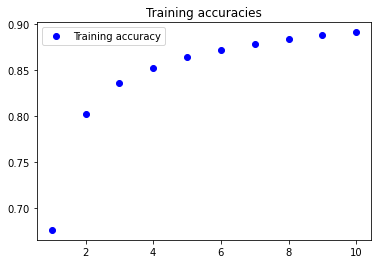

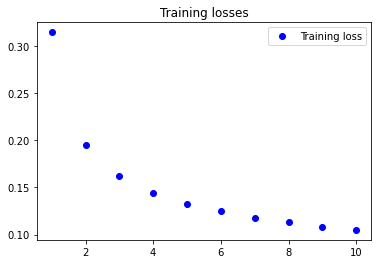

In [210]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.title('Training accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training losses')
plt.legend()

plt.show()

Saving the model. (This takes a long time as you have to save the embeddings)

In [211]:
# model1.save("keras_model")

Loading in again

In [212]:
# model1 = keras.models.load_model("keras_model")

## Applying the Model

We try the model on a test sentence

In [213]:
sentence = 'The United States might collapsez'.lower().split()

Convert the sentence words to indices

In [215]:
# Write your code
sentence_word_idxs = [word2idx[w] if w in word2idx else 1 for w in sentence]


The indices. Note the 1 at the end.

In [216]:
print('Sentence', sentence)
print('Sentence word indexes', sentence_word_idxs)

Sentence ['the', 'united', 'states', 'might', 'collapsez']
Sentence word indexes [358640, 373606, 343335, 245002, 1]


Predict the chunks. Call the variable `sent_chunk_predictions`

In [219]:
# Write your code
sent_chunk_predictions = model1.predict([sentence_word_idxs])

1/1 [==============================] - 0s 63ms/step


In [220]:
sent_chunk_predictions.shape

(1, 5, 23)

The estimated probabilities of the first chunk

In [221]:
sent_chunk_predictions[0][0]

array([2.8673696e-07, 1.7764591e-05, 3.0283685e-04, 2.1060423e-06,
       2.5845711e-06, 1.5754720e-06, 9.9852341e-01, 7.3398754e-04,
       1.1441005e-05, 1.5425043e-04, 2.5825986e-07, 8.7327080e-06,
       5.8786486e-07, 1.2575285e-06, 1.7351095e-06, 1.0515313e-06,
       1.0665933e-04, 8.9973946e-06, 1.1065702e-06, 8.1253330e-07,
       5.0150948e-07, 2.9164738e-07, 1.1784492e-04], dtype=float32)

We apply argmax to select the chunk

In [222]:
for word_nbr, chunk_predictions in enumerate(sent_chunk_predictions[0]):
    if sentence_word_idxs[word_nbr] in idx2word:
        print(idx2word[sentence_word_idxs[word_nbr]], end=': ')
    else:
        print(sentence[word_nbr], '/ukn', end=': ')
    print(idx2chunk.get(np.argmax(chunk_predictions)))

the: B-NP
united: I-NP
states: I-NP
might: B-VP
collapsez /ukn: I-VP


## Evaluating the Model

In [223]:
test_sentences = read_sentences(test_file)
test_dict = split_rows(test_sentences, column_names)
test_dict[1:2]

[[{'form': 'Rockwell', 'pos': 'NNP', 'chunk': 'B-NP'},
  {'form': 'said', 'pos': 'VBD', 'chunk': 'B-VP'},
  {'form': 'the', 'pos': 'DT', 'chunk': 'B-NP'},
  {'form': 'agreement', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'calls', 'pos': 'VBZ', 'chunk': 'B-VP'},
  {'form': 'for', 'pos': 'IN', 'chunk': 'B-SBAR'},
  {'form': 'it', 'pos': 'PRP', 'chunk': 'B-NP'},
  {'form': 'to', 'pos': 'TO', 'chunk': 'B-VP'},
  {'form': 'supply', 'pos': 'VB', 'chunk': 'I-VP'},
  {'form': '200', 'pos': 'CD', 'chunk': 'B-NP'},
  {'form': 'additional', 'pos': 'JJ', 'chunk': 'I-NP'},
  {'form': 'so-called', 'pos': 'JJ', 'chunk': 'I-NP'},
  {'form': 'shipsets', 'pos': 'NNS', 'chunk': 'I-NP'},
  {'form': 'for', 'pos': 'IN', 'chunk': 'B-PP'},
  {'form': 'the', 'pos': 'DT', 'chunk': 'B-NP'},
  {'form': 'planes', 'pos': 'NNS', 'chunk': 'I-NP'},
  {'form': '.', 'pos': '.', 'chunk': 'O'}]]

We create the $\mathbf{X}$ and $\mathbf{Y}$ sequences of symbols

In [224]:
X_test_symbs, Y_test_symbs = build_sequences(test_dict, key_x='form', key_y='chunk')
print('X_test:', X_test_symbs[1])
print('Y_test', Y_test_symbs[1])

X_test: ['rockwell', 'said', 'the', 'agreement', 'calls', 'for', 'it', 'to', 'supply', '200', 'additional', 'so-called', 'shipsets', 'for', 'the', 'planes', '.']
Y_test ['B-NP', 'B-VP', 'B-NP', 'I-NP', 'B-VP', 'B-SBAR', 'B-NP', 'B-VP', 'I-VP', 'B-NP', 'I-NP', 'I-NP', 'I-NP', 'B-PP', 'B-NP', 'I-NP', 'O']


Convert the $\mathbf{X}$ symbol sequence into an index sequence and pad it. Call the results `X_test_idx` and `X_test_padded`.

In [230]:
# Write your code
X_test_idx = [[word2idx[word] if word in word2idx else 1 for word in sample] for sample in X_test_symbs]
X_test_padded = pad_sequences(X_test_idx, padding = 'post')

In [231]:
print('X_test_idx:', X_test_idx[1])
print('X_test_padded:', X_test_padded[1])

X_test_idx: [311438, 316957, 358640, 48789, 90494, 152124, 194623, 362305, 349553, 17495, 46648, 337426, 1, 152124, 358640, 287224, 873]
X_test_padded: [311438 316957 358640  48789  90494 152124 194623 362305 349553  17495
  46648 337426      1 152124 358640 287224    873      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0]


In [232]:
X_test_padded.shape

(2012, 70)

Predict the chunks. Call the result `Y_test_hat_probs`

In [233]:
# Write your code
Y_test_hat_probs = model1.predict(X_test_padded)

63/63 [==============================] - 9s 112ms/step


In [234]:
print('Predictions', Y_test_hat_probs[1])

Predictions [[1.4478670e-05 5.6036981e-05 1.1067592e-04 ... 1.0991365e-04
  1.3199328e-04 2.2577338e-03]
 [2.1804633e-08 1.8830716e-06 3.0083009e-05 ... 3.2907803e-07
  2.2525483e-05 2.4125176e-04]
 [1.9371176e-09 4.8540392e-06 6.3606412e-06 ... 8.9781782e-09
  7.3422848e-07 2.1366817e-05]
 ...
 [3.0910300e-08 1.1541104e-05 1.4160571e-04 ... 1.5548193e-06
  4.0949749e-07 9.9839044e-01]
 [3.0910300e-08 1.1541104e-05 1.4160571e-04 ... 1.5548193e-06
  4.0949749e-07 9.9839044e-01]
 [3.0910300e-08 1.1541104e-05 1.4160571e-04 ... 1.5548193e-06
  4.0949749e-07 9.9839044e-01]]


In [242]:
idx2chunk

{1: 'B-ADJP',
 2: 'B-ADVP',
 3: 'B-CONJP',
 4: 'B-INTJ',
 5: 'B-LST',
 6: 'B-NP',
 7: 'B-PP',
 8: 'B-PRT',
 9: 'B-SBAR',
 10: 'B-UCP',
 11: 'B-VP',
 12: 'I-ADJP',
 13: 'I-ADVP',
 14: 'I-CONJP',
 15: 'I-INTJ',
 16: 'I-NP',
 17: 'I-PP',
 18: 'I-PRT',
 19: 'I-SBAR',
 20: 'I-UCP',
 21: 'I-VP',
 22: 'O'}

We now predict the whole test set and we store the results in each dictionary with the key `pchunk`

In [235]:
for sent, y_hat_probs in zip(test_dict, Y_test_hat_probs):
    sent_len = len(sent)
    y_hat_probs = y_hat_probs[:sent_len]
    y_hat = map(np.argmax, y_hat_probs)
    for word, ner_hat in zip(sent, y_hat):
        word['pchunk'] = idx2chunk[ner_hat]

A sentence example: `chunk` is the hand annotation and `pchunk` is the prediction.

In [236]:
test_dict[1]

[{'form': 'Rockwell', 'pos': 'NNP', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
 {'form': 'said', 'pos': 'VBD', 'chunk': 'B-VP', 'pchunk': 'B-VP'},
 {'form': 'the', 'pos': 'DT', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
 {'form': 'agreement', 'pos': 'NN', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
 {'form': 'calls', 'pos': 'VBZ', 'chunk': 'B-VP', 'pchunk': 'B-VP'},
 {'form': 'for', 'pos': 'IN', 'chunk': 'B-SBAR', 'pchunk': 'B-PP'},
 {'form': 'it', 'pos': 'PRP', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
 {'form': 'to', 'pos': 'TO', 'chunk': 'B-VP', 'pchunk': 'B-VP'},
 {'form': 'supply', 'pos': 'VB', 'chunk': 'I-VP', 'pchunk': 'I-VP'},
 {'form': '200', 'pos': 'CD', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
 {'form': 'additional', 'pos': 'JJ', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
 {'form': 'so-called', 'pos': 'JJ', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
 {'form': 'shipsets', 'pos': 'NNS', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
 {'form': 'for', 'pos': 'IN', 'chunk': 'B-PP', 'pchunk': 'B-PP'},
 {'form': 'the', 'pos': 'DT', 'chunk

We save the test set in a file to evaluate the performance of our model.

In [237]:
column_names = ['form', 'pos', 'chunk', 'pchunk']

In [238]:
def save(file, corpus_dict, column_names):
    """
    Saves the corpus in a file
    :param file:
    :param corpus_dict:
    :param column_names:
    :return:
    """
    i = 0
    with open(file, 'w', encoding='utf8') as f_out:
        i += 1
        for sentence in corpus_dict:
            sentence_lst = []
            for row in sentence:
                items = map(lambda x: row.get(x, '_'), column_names)
                sentence_lst += ' '.join(items) + '\n'
            sentence_lst += '\n'
            f_out.write(''.join(sentence_lst))

In [239]:
outfile = 'test_model1.out'

In [240]:
save(outfile, test_dict, column_names)

In [241]:
lines = open(outfile, encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
chunker_score = res['overall']['chunks']['evals']['f1']
chunker_score

0.8584242724867726

In [243]:
# 0.8983791168981722 bidi lstm non trainable 10 epochs
# 0.8954656530002717 bidi lstm non trainable 15 epochs
# 0.9038243480053603 bidi lstm trainable 10 epochs
# 0.9071813322795999 bidi lstm trainable 15 epochs


## Experiments

You will carry out experiments with two different recurrent networks: RNN and LSTM. You will also try at least two sets of parameters per network. In your report, you will present your results in a table like this one:

|Method|Parameters|Score|
|------|-----|-----|
|Baseline|  selecting the chunk tag which was most frequently associated with the current part-of-speech tag | 0.771 |
|RNN|  hidden_units=256, dropout=0.5 | 0.832 |
|RNN |  hidden_units=64, dropout=0.5 | 0.785 |
|LSTM |  hidden_units=256, dropout=0.5 | 0.859 |
|LSTM |  hidden_units=64, dropout=0.5 | 0.811 |
|  Akbik et al.|  xx| 0.967 |

The baseline is the one from the CoNLL 2000 site

## Submission

When you have written all the code and run all the cells, fill in your ID and as well as the name of the notebook.

In [246]:
STIL_ID = ["ni5324ro-s", "si7660da-s"] # Write your stil ids as a list
CURRENT_NOTEBOOK_PATH = os.path.join(os.getcwd(), 
                                     "lab_4.ipynb") # Write the name of your notebook

The submission code will send your answer. It consists of your best score and the confirmed entities. You need a score of more than 88 to pass

In [247]:
import json
ANSWER = json.dumps({'chunker_score': chunker_score})
ANSWER

'{"chunker_score": 0.8584242724867726}'

Now the moment of truth:
1. Save your notebook and
2. Run the cells below

In [248]:
SUBMISSION_NOTEBOOK_PATH = CURRENT_NOTEBOOK_PATH + ".submission.bz2"

In [249]:
import bz2
ASSIGNMENT = 4
API_KEY = "f581ba347babfea0b8f2c74a3a6776a7"

# Copy and compress current notebook
with bz2.open(SUBMISSION_NOTEBOOK_PATH, mode="wb") as fout:
    with open(CURRENT_NOTEBOOK_PATH, "rb") as fin:
        fout.write(fin.read())

In [250]:
res = requests.post("https://vilde.cs.lth.se/edan20checker/submit", 
                    files={"notebook_file": open(SUBMISSION_NOTEBOOK_PATH, "rb")}, 
                    data={
                        "stil_id": STIL_ID,
                        "assignment": ASSIGNMENT,
                        "answer": ANSWER,
                        "api_key": API_KEY,
                    },
               verify=True)

# from IPython.display import display, JSON
res.json()

{'msg': None,
 'status': 'incorrect',
 'signature': None,
 'submission_id': '3e770ca2-6622-49bf-927f-8384499ac20f'}

## Turning in your assignment

Now your are done with the program. To complete this assignment, you will:
1. Write a short individual report on your program. You will describe the architecture your used the different experiments you carried out and your results.
2. Read the article, <a href="https://www.aclweb.org/anthology/C18-1139"><i>Contextual String Embeddings for Sequence Labeling</i></a> by Akbik et al. (2018) and outline the main differences between their system and yours. A LSTM is a type of recurrent neural network, while CRF is a sort of beam search. You will tell the performance they reach on the corpus you used in this laboratory.

Submit your report as well as your notebook (for archiving purposes) to Canvas: https://canvas.education.lu.se/. To write your report, you can either
1. Write directly your text in Canvas, or
2. Use Latex and Overleaf (www.overleaf.com). This will probably help you structure your text. You will then upload a PDF file in Canvas.

The submission deadline is October 7, 2022.